# GNSS-R MERRByS Python Example code
This Jupyter Notebook contains some examples for the processing of the GNSS-Reflectometry (GNSS-R) data from www.merbys.co.uk.

Surrey Satellite Technology Ltd provides these functions under a permissive MIT license to make it easier for people to get started with this data source.


## Conventions

Data is segmented into 6 hour sections. When inputting start and stop times, these should use the boundary times of 03:00, 09:00, 15:00, 21:00.

## Contents
The examples are split into the following sections:
1. **Download data from FTP server** - downloads L1b or L2 data from TechDemoSat-1 from the MERRByS server over specified time range
2. **Example to read L1b Delay-Doppler maps level data** - reads Level1b metadata, filters it and generates a histogram and map
3. **Example to read Level 2 wind-speed** - Displays the Level 2 wind-speed data
4. **Other functions**
5. **Data search script** - Allows searching the Level 1b data for results by time and location

## Import helper functions
A number of helpper functions live in the notebook's `/GNSSR_Python` folder. These allow the notebook to focus on the high-level functions.

In [1]:
# Enable automatically reloading the local python files if they change
%load_ext autoreload
%autoreload 2

#Import local python files
import os
import sys
module_path = os.getcwd() + '\\GNSSR_Python'
if module_path not in sys.path:
    sys.path.append(module_path)

#Import profiler
import cProfile

## 1. Data download
**The following contains a Python script to download L1b or L2 data from the MERRByS server.**

All the data could be downloaded using any FTP client, but this script is provided to make it easier to select a subset of interest.

The functions used for processing MERRByS data expect the files to be available on a local disk drive with the same directory structure as that used on the MERRByS FTP server. 

For example the following will download 24 hours of data

e.g. downloadData('20170217T21:00:00', '20170218T21:00:00', {'L1B': True, 'L2_FDI': True, 'L2_CBRE_v0_5': True}, 'c:\merrbysData\');

*	This will download L1b and L2 in the time range specified into the c:\merrbysData folder.

** You will need to change to following to use your MERRByS FTP Credentials to log-in **


### Configuration

In [5]:
import datetime

# Destination to write data to
dataFolder = os.path.join(os.getcwd() , 'Data\\')
#The FTP data access folder 'Data' for regular users or 'DataFast' for low latency access for approved users
ftpDataFolder = 'Data'  # 'Data' or 'DataFast'
# Location and access to the FTP server
 ## ENTER CREDENTIALS HERE
userName = ''
passWord = ''
ftpServer = 'ftp.merrbys.co.uk'

if len(userName) == 0:
    print('Enter FTP credentials!')

#Time range of interest
# Data is segmented every 6 hours so hours must be one of [3, 9, 15, 21]
startTime = datetime.datetime(2017, 2, 1, 3, 0, 0)
stopTime = datetime.datetime(2017, 2, 10, 21, 0, 0)

#Data levels to download
#  L1b is Delay-Doppler maps
#  L2 FDI  Is the original FDI ocean windspeed algorithm
#  L2 CBRE  Is the improved ocean windspeed algorithm
dataLevels = {'L1B': True, 'L2_FDI': True, 'L2_CBRE_v0_5': True}

### Run download

In [6]:
# Download data from MERRByS server
# Collect all available files within a given date and time range
#Import GNSSR
from GNSSR import DownloadData
DownloadData(startTime, stopTime, dataFolder, ftpServer, userName, passWord, dataLevels, ftpDataFolder)

Starting download
Complete. Got: 35 segments


## 2. Generate histogram from Level1b metadata
** The following produces two plots based on the Level 1B metadata.**
These are:
* a 2D histogram of DDM Peak SNR vs. Antenna Gain
* an averaged map of Peak SNR

Data is filtered to specular points only over the ocean and when there is no direct signal interference from code-wrapping.

In [7]:
# Configuration of the routine for processing the Level1b histogram
import datetime

# Destination to read data from
dataFolder = os.path.join(os.getcwd() , 'Data\\')

#Time range of interest
# Data is segmented every 6 hours so hours must be one of [3, 9, 15, 21]
startTime = datetime.datetime(2017, 2, 1, 21, 0, 0)
stopTime = datetime.datetime(2017, 2, 10, 21, 0, 0)

Reading file 2017-02/02/H00...
Reading file 2017-02/02/H06...
Reading file 2017-02/02/H12...
Reading file 2017-02/08/H18...
Reading file 2017-02/09/H00...
Reading file 2017-02/09/H06...
Reading file 2017-02/09/H12...
Reading file 2017-02/09/H18...
Reading file 2017-02/10/H00...
Reading file 2017-02/10/H06...
Reading file 2017-02/10/H12...
Plotting histogram


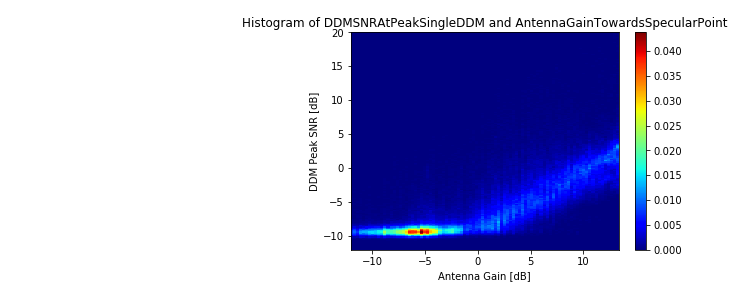

Plotting map


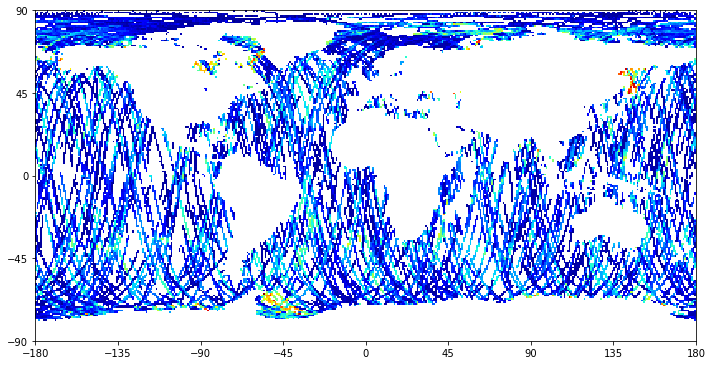

In [8]:
import numpy as np
import scipy as sp
import sys
import os
import h5py
import matplotlib.pyplot as plt
import ipywidgets as widgets
from GNSSR import *
from CoastalDistanceMap import *
from MapPlotter import *
    
def RunMERRBySLevel1bHistogramAndMapExample():
    #Ignore divide by NaN
    np.seterr(divide='ignore', invalid='ignore')

    # Select the data names to extract and plot
    yName = 'DDMSNRAtPeakSingleDDM'
    xName = 'AntennaGainTowardsSpecularPoint'
    # Filter by the following data name
    filterName = 'DirectSignalInDDM'
    #filterOceanOrLand = 'Ocean'
    landDistanceThreshold = 50 # km
    # Filter by geographic area - if enabled
    searchLimitsEnabled = False
    searchLatLimit = [-10, 10]
    searchLonLimit = [-10, 10]
    
    coastalDistanceMap = CoastalDistanceMap()
    coastalDistanceMap.loadMap(os.path.join(os.getcwd(), 'GNSSR_Python', 'landDistGrid_0.10LLRes_hGSHHSres.nc'))
    
    #Generate a list of possible files in the range startTime to stopTime
    dataList = FindFiles(startTime, stopTime)

    #Initialising lists to ensure they are empty
    x = np.array([])
    y = np.array([])
    
    mapPlotter = MapPlotter(100e3) #Map grid in km (at equator)
    
    #Generate file input list for range
    for entry in dataList:
        entryFolder = FolderFromTimeStamp(entry)
        #Create file path string
        filePath = dataFolder + 'L1B\\' + entryFolder.replace('/','\\') + '\\metadata.nc'

        try:
            f = h5py.File(filePath, 'r')
        except OSError as e:
            #File does not exist
            #As TDS-1 is run periodically, many time segment files are not populated
            #print(e)
            continue

        print ('Reading file %s...' % entryFolder)

        # Loop through all the tracks
        trackNumber = 0
        while True:
            #Group name in NetCDF is 6 digit string
            groupName = str(trackNumber).zfill(6)

            try:
                #Get data into numpy arrays
                directSignalInDDM = f['/' + groupName + '/DirectSignalInDDM'][:] 
                x_vals = f['/' + groupName + '/' + xName][:]
                y_vals = f['/' + groupName + '/' + yName][:]
                
                specularPointLon = f['/' + groupName + '/SpecularPointLon'][:]
                specularPointLat = f['/' + groupName + '/SpecularPointLat'][:]
            except:
                #End of data
                break
            
            # Filter the data
            # Ocean  - coastal distance            
            coastDistance = coastalDistanceMap.getDistanceToCoast(specularPointLon, specularPointLat)
            
            #Initialise filter vector to all ones
            acceptedData = np.ones(np.shape(directSignalInDDM))
            # Filter out directSignalInDDM when the direct signal is in the
            # delay-doppler space of the reflection DDM
            acceptedData = np.logical_and(acceptedData, directSignalInDDM==0)
            # Filter out land coastDistance=NaN
            acceptedData = np.logical_and(acceptedData, np.isfinite(coastDistance))
            # Filter out coastal data 
            acceptedData = np.logical_and(directSignalInDDM==0, coastDistance>landDistanceThreshold)
            # Filter out where there could be sea-ice - currently disabled
            #acceptedData = np.logical_and(acceptedData, np.abs(specularPointLat) < 55)
            # Filter to geographic area
            if searchLimitsEnabled:
                acceptedData = np.logical_and(acceptedData, np.logical_and(specularPointLat > searchLatLimit[0], specularPointLat < searchLatLimit[1]))
                acceptedData = np.logical_and(acceptedData, np.logical_and(specularPointLon > searchLonLimit[0], specularPointLon < searchLonLimit[1]))

            #Apply the filter
            filtered_x = x_vals[acceptedData]
            filtered_y = y_vals[acceptedData]
            filtered_lat = specularPointLat[acceptedData]
            filtered_lon = specularPointLon[acceptedData]
        
            #Concatenate filtered values to output in histogram
            x = np.concatenate((x, filtered_x))
            y = np.concatenate((y, filtered_y))
            #Accumulate values into the map
            mapPlotter.accumulateDataToMap(filtered_lon, filtered_lat, filtered_y)
            # Go to next track
            trackNumber = trackNumber + 1
            
        f.close()
    
    
    #Plot the data as a histogram
    print('Plotting histogram')
    plt.hist2d(x,y,bins=200, normed=True, cmap = 'jet')
    #plt.figsize=(24, 40)

    #Modify plot
    plt.xlabel('Antenna Gain [dB]')
    plt.ylabel('DDM Peak SNR [dB]')
    plt.title('Histogram of ' + yName + ' and ' + xName)
    plt.xlim([-12,max(x)])
    plt.ylim([-12,20])
    plt.colorbar()
    #plt.tight_layout()
    plt.show()
    
    #Plot the data on a map
    print('Plotting map')
    mapPlotter.plotMap()

RunMERRBySLevel1bHistogramAndMapExample()

## 3. Plot wind speed from Level 2 data set
** The following produces a plots of the Level 2 wind speed output of the FDI algorithm on a map**

Reading file 2017-02/02/H00...
Reading file 2017-02/02/H06...
Reading file 2017-02/02/H12...
Reading file 2017-02/08/H18...
Reading file 2017-02/09/H00...
Reading file 2017-02/09/H06...
Reading file 2017-02/09/H12...
Reading file 2017-02/09/H18...
Reading file 2017-02/10/H00...
Reading file 2017-02/10/H06...
Reading file 2017-02/10/H12...


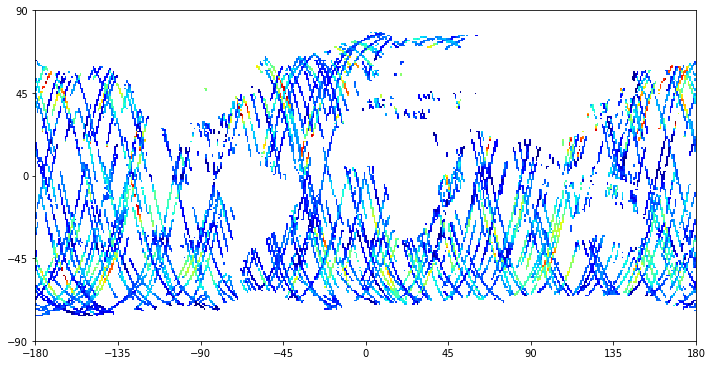

In [10]:
import numpy as np
import scipy as sp
import sys
import os
import h5py
import matplotlib.pyplot as plt
import ipywidgets as widgets
from GNSSR import *
from CoastalDistanceMap import *
from MapPlotter import *
    
def RunMERRBySLevel2MapExample():
    #Configuration of L2 Data type
    l2DataName = 'L2_FDI' # 'L2_FDI' or 'L2_CBRE_v0_5'
    
    #Ignore divide by NaN
    np.seterr(divide='ignore', invalid='ignore')
    # Set default figure size
    plt.rcParams['figure.figsize'] = (12,8)
    
    #Generate a list of possible files in the range startTime to stopTime
    dataList = FindFiles(startTime, stopTime)

    #Initialising lists to ensure they are empty
    x = np.array([])
    y = np.array([])
    
    mapPlotter = MapPlotter(100e3) #Map grid in km (at equator)
    
    #Generate file input list for range
    for entry in dataList:
        entryFolder = FolderFromTimeStamp(entry)
        #Create file path string
        filePath = dataFolder + l2DataName + '\\' + entryFolder.replace('/','\\') + '\\' + l2DataName + '.nc'

        try:
            f = h5py.File(filePath, 'r')
        except OSError as e:
            #File does not exist
            #As TDS-1 is run periodically, many time segment files are not populated
            #print(e)
            continue

        print ('Reading file %s...' % entryFolder)

        #Get data into numpy arrays
        windSpeed = f['/WindSpeed'][:] 

        specularPointLon = f['/SpecularPointLon'][:]
        specularPointLat = f['/SpecularPointLat'][:]
            
        mapPlotter.accumulateDataToMap(specularPointLon, specularPointLat, windSpeed)
            
        f.close()
    
    #Plot the data on a map
    mapPlotter.plotMap()
    

RunMERRBySLevel2MapExample()

## 4. Other functions
### Test the loading in of coastal distance map
The following will load the Coastal distance map (resolution 0.1 degree) and look-up the distance over a grid of latitude and longitudes (testing with a lower resolution grid for speed of test).

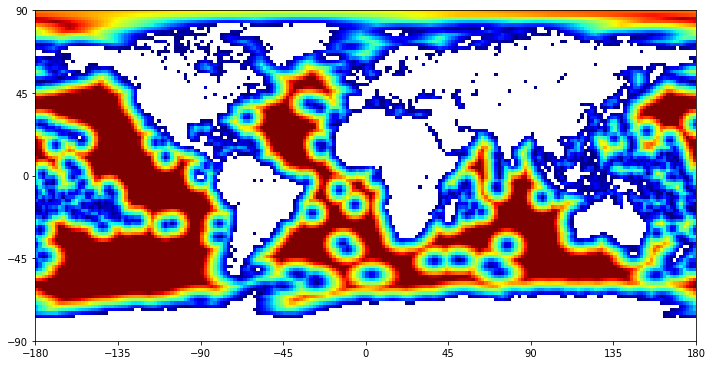

In [11]:
from CoastalDistanceMap import *
coastalDistanceMap = CoastalDistanceMap()
coastalDistanceMap.loadMap(os.path.join(os.getcwd(), 'GNSSR_Python', 'landDistGrid_0.10LLRes_hGSHHSres.nc'))
coastalDistanceMap.displayMapTest()

## 5. Data search
### Search for data within the MERRByS site
The following code can be used to search for data on the MERRByS service.
Search can be given with latitude / longitude as well as date/time limits.
 - The data for the time-range is downloaded to the data folder (if not already there)
 - Each file is loaded and filtered
 - The resulting matches are output

In [12]:
# Configuration of the routine for searching for Level 1b data
import datetime
from GNSSR import *

# Destination to read data from
dataFolder = os.path.join(os.getcwd() , 'Data\\')
#The FTP data access folder 'Data' for regular users or 'DataFast' for low latency access for approved users
ftpDataFolder = 'Data'  # 'Data' or 'DataFast'

#Time range of interest
# Data is segmented every 6 hours so hours must be one of [3, 9, 15, 21]
startTime = datetime.datetime(2017, 2, 1, 21, 0, 0)
stopTime = datetime.datetime(2017, 2, 10, 21, 0, 0)

#Geographical limits (in degrees as [min, max])
searchLatLimit = [-20, -10]
searchLonLimit = [-10, 10]

# Check that the required data is downloaded
DownloadData(startTime, stopTime, dataFolder, ftpServer, userName, passWord, dataLevels, ftpDataFolder)

def SearchLevel1bData(startTime, stopTime, searchLatLimit, searchLonLimit):
    '''Function for searching through the MERRByS Level 1b data by time and location'''
    
    #Generate a list of possible files in the range startTime to stopTime
    dataList = FindFiles(startTime, stopTime)

    #Initialising lists to ensure they are empty
    dataNameList = []
    trackNumberList = []
    startTimeList = []
    endTimeList = []
    
    #Generate file input list for range
    for entry in dataList:
        entryFolder = FolderFromTimeStamp(entry)
        #Create file path string
        filePath = dataFolder + 'L1B\\' + entryFolder.replace('/','\\') + '\\metadata.nc'

        try:
            f = h5py.File(filePath, 'r')
        except OSError as e:
            #File does not exist
            #As TDS-1 is run periodically, many time segment files are not populated
            #print(e)
            continue

        print ('Reading file %s...' % entryFolder)

        # Loop through all the tracks
        trackNumber = 0
        while True:
            #Group name in NetCDF is 6 digit string
            groupName = str(trackNumber).zfill(6)

            try:
                #Get data into numpy arrays
                integrationMidPointTime = f['/' + groupName + '/IntegrationMidPointTime'][:]
                specularPointLon = f['/' + groupName + '/SpecularPointLon'][:]
                specularPointLat = f['/' + groupName + '/SpecularPointLat'][:]
            except:
                #End of data
                break
            
            #Initialise filter vector to all ones
            acceptedData = np.ones(np.shape(integrationMidPointTime))
            # Filter to geographic area
            acceptedData = np.logical_and(acceptedData, np.logical_and(specularPointLat > searchLatLimit[0], specularPointLat < searchLatLimit[1]))
            acceptedData = np.logical_and(acceptedData, np.logical_and(specularPointLon > searchLonLimit[0], specularPointLon < searchLonLimit[1]))

            #Apply the filter
            filtered_time = integrationMidPointTime[acceptedData]
        
            # Add the data to list of matches
            if filtered_time.size > 0:
                dataNameList.append(entryFolder)
                trackNumberList.append(trackNumber)
                
                startOfIntersect = MatlabToPythonDateNum(np.min(filtered_time))
                endOfIntersect = MatlabToPythonDateNum(np.max(filtered_time))
                
                startTimeList.append(startOfIntersect)
                endTimeList.append(endOfIntersect)
        
            # Go to next track
            trackNumber = trackNumber + 1
            
        f.close()
        
    return dataNameList, trackNumberList, startTimeList, endTimeList

# Run the search
dataNameList, trackNumberList, startTimeList, endTimeList = SearchLevel1bData(startTime, stopTime, searchLatLimit, searchLonLimit)

# Print out the search results
print("## Search results ##")
print("DataID,\t\t TrackNumber,\t Start Time,\t\t\t End Time")
for i in range(len(dataNameList)):
    print(str(dataNameList[i]) + ",\t" + str(trackNumberList[i]) +  ",\t\t" + str(startTimeList[i]) +  ",\t" + str(endTimeList[i]))

Starting download
Complete. Got: 30 segments
Reading file 2017-02/02/H00...
Reading file 2017-02/02/H06...
Reading file 2017-02/02/H12...
Reading file 2017-02/08/H18...
Reading file 2017-02/09/H00...
Reading file 2017-02/09/H06...
Reading file 2017-02/09/H12...
Reading file 2017-02/09/H18...
Reading file 2017-02/10/H00...
Reading file 2017-02/10/H06...
Reading file 2017-02/10/H12...
## Search results ##
DataID,		 TrackNumber,	 Start Time,			 End Time
2017-02/02/H00,	76,		2017-02-02 00:12:01.999001,	2017-02-02 00:15:19.999003
2017-02/02/H00,	89,		2017-02-02 00:10:29.998997,	2017-02-02 00:13:29.998996
2017-02/02/H00,	90,		2017-02-02 00:10:48.998994,	2017-02-02 00:13:52.999002
2017-02/02/H00,	91,		2017-02-02 00:09:52.998996,	2017-02-02 00:11:41.998999
2017-02/02/H00,	146,		2017-02-02 01:48:41.999004,	2017-02-02 01:51:28.999003
2017-02/02/H12,	123,		2017-02-02 12:27:34.998999,	2017-02-02 12:30:35.999003
2017-02/02/H12,	126,		2017-02-02 12:28:27.999004,	2017-02-02 12:28:40.999004
2017-02/02